In [1]:
import pandas as pd

# Path to csv file
data_path = "C:\\Users\\S1157\\OneDrive\\Documents\\implementation6.20\\データセット\\mis_information.csv"
# Load the file into a pandas DataFrame work
df = pd.read_csv(data_path)

#Display the structure and contents of the DataFrame
print(df.head())

              id                                               text  label
0     BBCDanielS  Charlie Hebdo became well known for publishing...    0.0
1      robbylevy  Now 10 dead in a shooting there today RT "@BBC...    0.0
2  ModerateInAll  @BBCDanielS @BBCWorld I'm guessing this is bei...    0.0
3    GabTarquini  @BBCDanielS @BBCWorld why would you mention th...    0.0
4  freethought41            @BBCDanielS @BBCWorld perps identified?    0.0


In [2]:

texts = df['text'].tolist()
if df['label'].isnull().any():
    df['label'].fillna(0, inplace=True)  # Replace NaN with 0 or any appropriate value

df['label'] = df['label'].replace([float('inf'), float('-inf')], 0)  # Replace inf with 0 or any appropriate value

# Convert labels to binary integers (0 and 1)
labels = df['label'].round().astype(int)
labels = labels.tolist()

C:\Users\S1157\AppData\Local\Temp\ipykernel_31916\1901570642.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['label'].fillna(0, inplace=True)  # Replace NaN with 0 or any appropriate value


In [3]:
from sklearn.model_selection import train_test_split
# Split the data into training and validation sets (e.g., 80% training, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [4]:
print(train_labels)

[1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 

In [4]:
batch_size = 32
learning_rate = 2e-5
num_epochs = 7
warmup_proportion = 0.1


In [5]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.enabled = False
# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)


# Tokenize training data
train_encodings = tokenizer(
    train_texts,
    padding='max_length',  # Pad to max_length
    truncation=True,
    max_length=100,  # Set max_length to match average length
    return_tensors="pt")

# Tokenize test data
val_encodings = tokenizer(
    val_texts,
    padding='max_length',  # Pad to max_length
    truncation=True,
    max_length=100,  # Set max_length to match average length
    return_tensors="pt")

train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

# Prepare dataset and dataloader
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Instantiate CustomDataset with tokenized inputs and labels
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)


c:\Users\S1157\anaconda3\Lib\site-packages\huggingface_hub-0.23.0-py3.8.egg\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
# Define DataLoader for training dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

optimizer = AdamW(model.parameters(), lr=learning_rate)

# Set up optimizer and scheduler
total_steps = len(train_loader) * num_epochs  # Total number of training steps
warmup_steps = int(total_steps * warmup_proportion)  # Number of warmup steps

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_epoch_loss = 0.0
    train_correct_predictions = 0
    train_total_predictions = 0

    for batch in train_loader:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)

        labels = labels.long()
        outputs = model(**inputs)
        logits = outputs.logits

        loss = torch.nn.functional.cross_entropy(logits, labels)  # Cross-entropy loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_epoch_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        train_correct_predictions += torch.sum(preds == labels).item()
        train_total_predictions += len(labels)

    train_loss = train_epoch_loss / len(train_loader)
    train_accuracy = train_correct_predictions / train_total_predictions
    train_loss_list.append(train_loss)
    train_acc_list.append(train_accuracy)

    # Validation phase
    model.eval()
    val_epoch_loss = 0.0
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)
            labels = labels.long()  # Ensure labels are of type torch.long

            outputs = model(**inputs)
            logits = outputs.logits
            logits = logits.float()  # Ensure logits are of type torch.float if necessary

            # Compute cross-entropy loss
            val_loss = torch.nn.functional.cross_entropy(logits, labels)

            val_epoch_loss += val_loss.item()
            val_preds = torch.argmax(logits, dim=1)
            val_correct_predictions += torch.sum(val_preds == labels).item()
            val_total_predictions += len(labels)

     # Calculate average validation loss and accuracy
    val_loss = val_epoch_loss / len(val_loader)
    val_accuracy = val_correct_predictions / val_total_predictions


    print(f"Epoch [{epoch + 1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
    
    # Save the trained model and tokenizer
output_dir = "C:\\Users\\S1157\\OneDrive\\Documents\\implementation6.20\\model\\BERT_7"
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to: {output_dir}")


c:\Users\S1157\anaconda3\Lib\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\S1157\AppData\Local\Temp\ipykernel_31916\151353307.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\S1157\AppData\Local\Temp\ipykernel_31916\151353307.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Epoch [1/7], Train Loss: 0.3944, Train Acc: 0.8345, Val Loss: 0.2780, Val Acc: 0.8827
Epoch [2/7], Train Loss: 0.1993, Train Acc: 0.9162, Val Loss: 0.1979, Val Acc: 0.9139
Epoch [3/7], Train Loss: 0.1227, Train Acc: 0.9468, Val Loss: 0.2000, Val Acc: 0.9209
Epoch [4/7], Train Loss: 0.0750, Train Acc: 0.9678, Val Loss: 0.2449, Val Acc: 0.9190
Epoch [5/7], Train Loss: 0.0484, Train Acc: 0.9790, Val Loss: 0.2774, Val Acc: 0.9227
Epoch [6/7], Train Loss: 0.0325, Train Acc: 0.9869, Val Loss: 0.3118, Val Acc: 0.9218
Epoch [7/7], Train Loss: 0.0222, Train Acc: 0.9907, Val Loss: 0.3559, Val Acc: 0.9225
Model and tokenizer saved to: C:\Users\S1157\OneDrive\Documents\implementation6.20\model\BERT_7


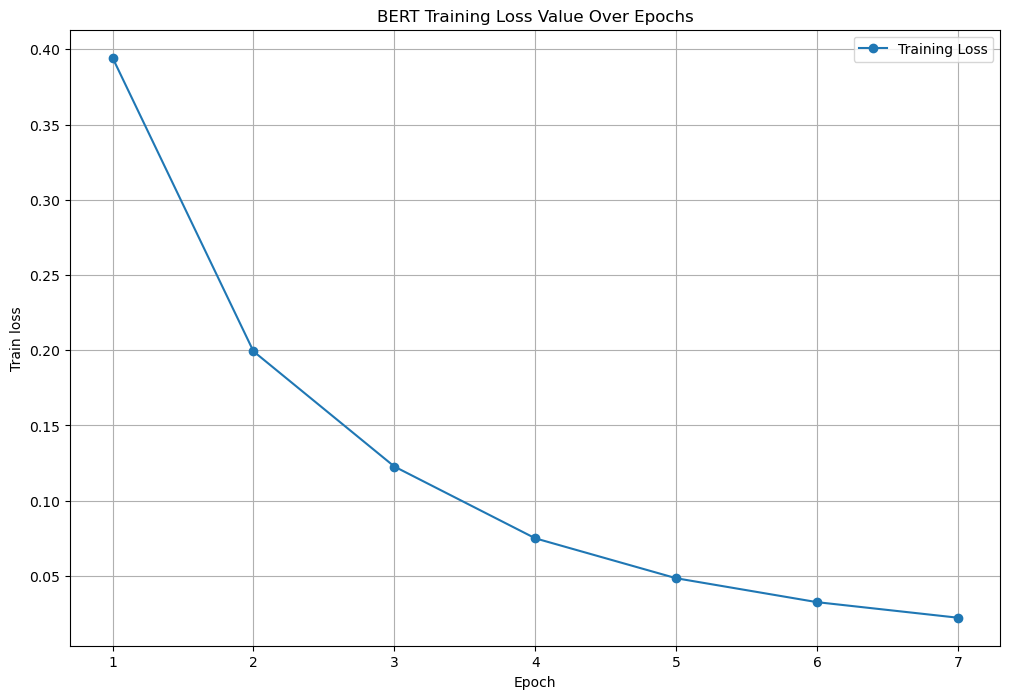

In [7]:
import matplotlib.pyplot as plt
# Plotting the training progress
plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss', marker='o')
#plt.plot(range(1, num_epochs + 1), val_loss_list, label='Validation Loss', marker='o')
#plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy', marker='o')
#plt.plot(range(1, num_epochs + 1), val_acc_list, label='Validation Accuracy', marker='o')
plt.title('BERT Training Loss Value Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

In [8]:
val_acc_list_self = [0.8827, 0.9139, 0.9209, 0.9190, 0.9227, 0.9218, 0.9225]
print(val_acc_list_self)


[0.8827, 0.9139, 0.9209, 0.919, 0.9227, 0.9218, 0.9225]


In [9]:

print(train_acc_list)

[0.8345497327909388, 0.916247906197655, 0.9467775384860811, 0.9677953258355269, 0.9789822126505544, 0.9868987796123474, 0.990667623833453]


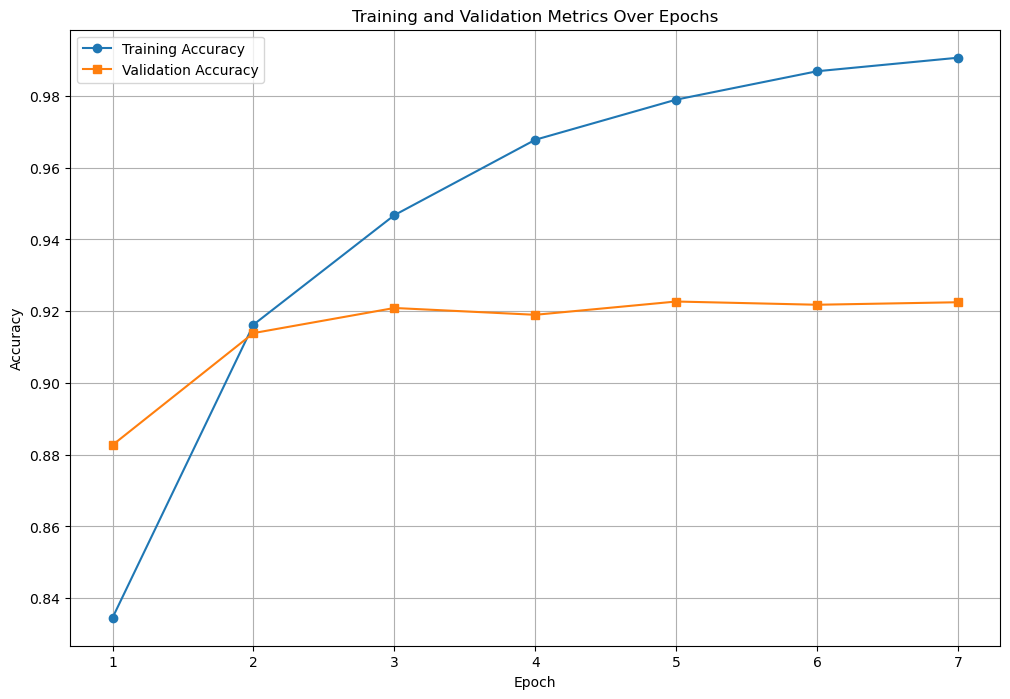

In [10]:
num_epochs = len(train_acc_list)  # Assuming train_acc_list is defined elsewhere



# Check the length of val_acc_list_self
assert len(val_acc_list_self) == num_epochs, "BERT Validation accuracy list length does not match num_epochs"

# Plotting the training and validation accuracy over epochs
plt.figure(figsize=(12, 8))
plt.plot(range(1, num_epochs + 1), train_acc_list, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), val_acc_list_self, label='Validation Accuracy', marker='s')
plt.title('Training and Validation Metrics Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.grid(True)
plt.show()

In [11]:
with torch.no_grad():
    all_preds = []
    all_labels = []
    for batch in val_loader:
        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
        labels = batch['labels'].to(device)
        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())


C:\Users\S1157\AppData\Local\Temp\ipykernel_31916\151353307.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
C:\Users\S1157\AppData\Local\Temp\ipykernel_31916\151353307.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

valid_indices = ~np.isnan(all_labels)
all_labels = np.array(all_labels)[valid_indices]
all_preds = np.array(all_preds)[valid_indices]

# Compute and print classification report and confusion matrix
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      9752
           1       0.84      0.80      0.82      2785

    accuracy                           0.92     12537
   macro avg       0.89      0.88      0.89     12537
weighted avg       0.92      0.92      0.92     12537

[[9340  412]
 [ 559 2226]]


In [13]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
model_path = "C:\\Users\\S1157\\OneDrive\\Documents\\implementation6.20\\model\\BERT_7"
# Load the tokenizer and model
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

In [14]:
model.eval

<bound method Module.eval of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm):

In [15]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

Total parameters: 109483778
